<h1>Experiment with Gradient Descent for Linear Regression.</h1>

Here we'll use the ancient Boston housing data set to see how regression models can be trained with gradient descent.

This notebook features the <a href="http://stanford.edu/~mwaskom/software/seaborn/index.html">seaborn package</a> which makes all plots prettier and has some nice built-in features like the correlation plot you'll see below.

In [8]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns  # 'pip install seaborn' if not already installed
import numpy as np
import pandas as pd
import time
from numpy.linalg import inv
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

np.set_printoptions(precision=4, suppress=True)

Load the Boston housing data. This data set is pretty out-of-date since it was collected in the 1970s. Each of the 506 entries represents a local district in the Boston area. The standard target variable is the median home value in the district (in 1000s of dollars). Let's print out the description along with a histogram of the target. Notice that the distribution of median value is roughly Gaussian with a significant outlier -- there are around 15 very wealthy districts.

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

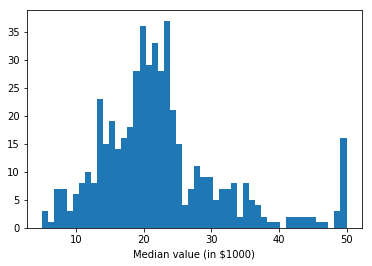

In [3]:
boston = load_boston()
X, Y = boston.data, boston.target
plt.hist(Y, 50)
plt.xlabel('Median value (in $1000)')
print(boston.DESCR)

As usual, let's create separate training and test data.

In [4]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test. JTODO upgrade to sklearn splitter
train_data, train_labels = X[:350], Y[:350]
test_data, test_labels = X[350:], Y[350:]

Before we start making any predictions, let's get some intuition about the data by examining the correlations. Seaborn makes it easy to visualize a correlation matrix. Note, for example, that value and crime rate are negatively correlated: districts with lower crime rates tend to be higher valued.

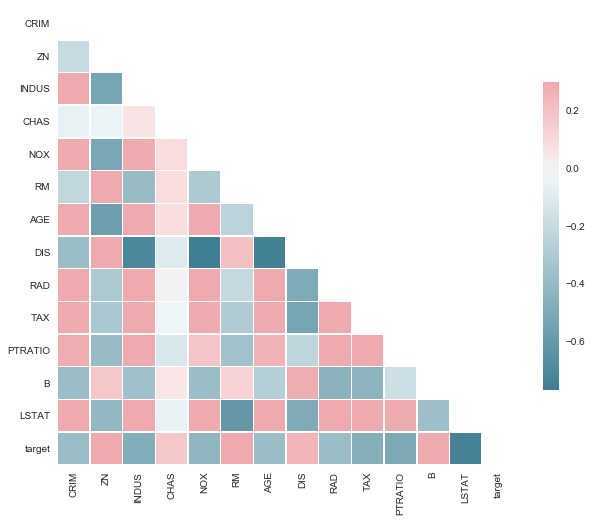

In [25]:
# Load Housing Data with Pandas Dataframe, include target
col_names = boston['feature_names'].tolist()
col_names.append('target')
boston_df = pd.DataFrame(np.c_[boston['data'], boston['target']], columns=col_names)

correlation_matrix = boston_df.corr()

# Use seaborn to create a pretty correlation heatmap.
sns.set(style="white")
fig, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation_matrix, cmap=cmap, mask=mask, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()

Ok. Let's implement gradient descent. It's more efficient to implement it with vector calculations, though this may be a bit more difficult to understand at first glance. Try to think through each step and make sure you understand how it works.

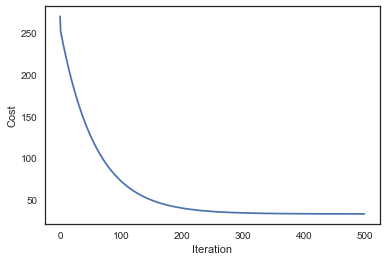

In [26]:
# eta is the learning rate; smaller values will tend to give slower but more precise convergence.
# num_iters is the number of iterations to run.
def gradient_descent(train_data, target_data, eta, num_iters):
    # Add a 1 to each feature vector so we learn an intercept.
    X = np.c_[np.ones(train_data.shape[0]), train_data]
    
    # m = number of samples, k = number of features
    m, k = X.shape
    
    # Initially, set all the parameters to 1.
    theta = np.ones(k)
    
    # Keep track of costs after each step.
    costs = []
    
    for iter in range(0, num_iters):
        # Get the current predictions for the training examples given the current estimate of theta.
        hypothesis = np.dot(X, theta)
        
        # The loss is the difference between the predictions and the actual target values.
        loss = hypothesis - target_data
        
        # In standard linear regression, we want to minimize the sum of squared losses.
        cost = np.sum(loss ** 2) / (2 * m)
        costs.append(cost)
        
        # Compute the gradient.
        gradient = np.dot(X.T, loss) / m

        # Update theta, scaling the gradient by the learning rate.
        theta = theta - eta * gradient
        
    return theta, costs

# Run gradient descent and plot the cost vs iterations.
theta, costs = gradient_descent(train_data[:,0:1], train_labels, .01, 500)
plt.plot(costs)
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

Let's compare our results to sklearn's regression as well as the algebraic solution to "ordinary least squares". Try increasing the number of iterations above to see whether we get closer.

In [28]:
def OLS(X, Y):
    # Add the intercept.
    X = np.c_[np.ones(X.shape[0]), X]
    
    # We use np.linalg.inv() to compute a matrix inverse.
    return np.dot(inv(np.dot(X.T, X)), np.dot(X.T, Y))

ols_solution = OLS(train_data[:,0:1], train_labels)

lr = LinearRegression(fit_intercept=True)
lr.fit(train_data[:,0:1], train_labels)

print('Our estimated theta:     %.4f + %.4f*CRIM' %(theta[0], theta[1]))
print('OLS estimated theta:     %.4f + %.4f*CRIM' %(ols_solution[0], ols_solution[1]))
print('sklearn estimated theta: %.4f + %.4f*CRIM' %(lr.intercept_, lr.coef_[0]))

Our estimated theta:     23.3397 + -0.3466*CRIM
OLS estimated theta:     23.6380 + -0.3575*CRIM
sklearn estimated theta: 23.6380 + -0.3575*CRIM


Ok, let's try fitting a model that uses more of the variables. Let's run just a few iterations and check the cost function.

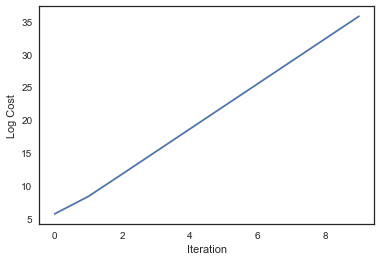

In [30]:
num_feats = 5
theta, costs = gradient_descent(train_data[:,0:num_feats], train_labels, .01, 10)
plt.plot([k for k in map(np.log, costs)])
plt.xlabel('Iteration'), plt.ylabel('Log Cost')
plt.show()

The cost is increasing and fast! This can happen when the learning rate is too large. The updated parameters skip over the optimum and the cost ends up larger than it was before. Let's reduce the learning rate and try again. 

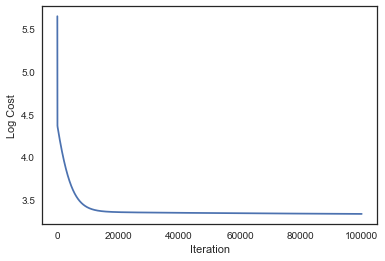

Training time: 1.81 secs
Our estimated theta: [ 26.0983  -0.2143   0.0345  -0.4745   4.9007   2.8408]
OLS estimated theta: [ 32.5831  -0.1926   0.0218  -0.3213   5.4266 -11.8824]


In [32]:
start_time = time.time()
theta, costs = gradient_descent(train_data[:,0:num_feats], train_labels, .001, 100000)
train_time = time.time() - start_time
plt.plot([k for k in map(np.log, costs)])
plt.xlabel('Iteration'), plt.ylabel('Log Cost')
plt.show()

print('Training time: %.2f secs' %train_time)
print('Our estimated theta:', theta)
print('OLS estimated theta:', OLS(train_data[:,0:num_feats], train_labels))

This is getting pretty slow, and it looks like it hasn't yet converged (see the last value of theta, especially). The scale of the parameters can also make convergence difficult. Let's examine the distributions of the features we're using.

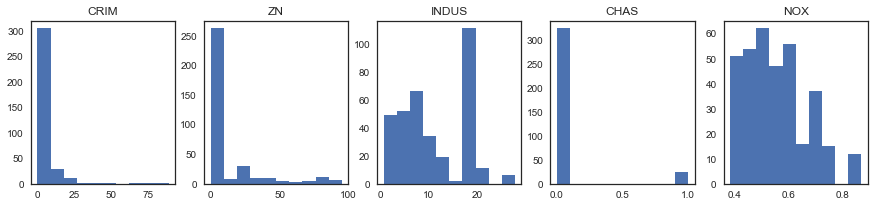

In [33]:
plt.figure(figsize=(15, 3))
for feature in range(num_feats):
    plt.subplot(1, num_feats, feature+1)
    plt.hist(train_data[:,feature])
    plt.title(boston.feature_names[feature])

Clearly, the distribution of the feature values varies a great deal. Let's apply the standard scaler -- subtract the mean, divide by the standard deviation -- for each feature. This is built in as a preprocessor in sklearn. We run the fit() function on the training data and then apply the transformation to both train and test data. We don't fit on the test data because this would be cheating -- we shouldn't know in advance the mean and variance of the feature values in the test data, so we assume they are the same as the training data.

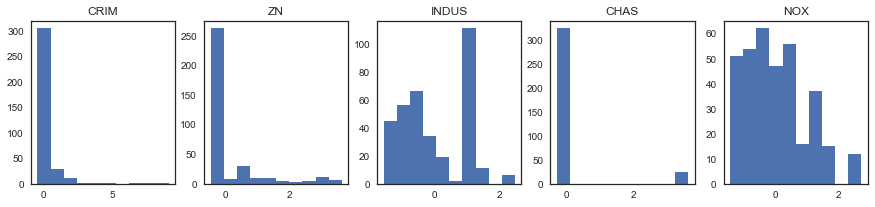

In [34]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

plt.figure(figsize=(15, 3))

for feature in range(5):
    plt.subplot(1, 5, feature+1)
    plt.hist(scaled_train_data[:,feature])
    plt.title(boston.feature_names[feature])

Ok, let's try gradient descent again. We can increase the learning rate and decrease the number of iterations.

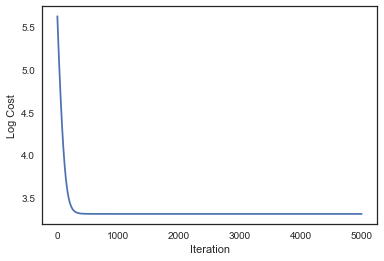

Training time: 0.12 secs
Our estimated theta: [ 22.2951  -1.8194   0.5028  -2.1295   1.3976  -1.3729]
OLS estimated theta: [ 22.2951  -1.8194   0.5028  -2.1295   1.3976  -1.3729]


In [36]:
start_time = time.time()
theta, costs = gradient_descent(scaled_train_data[:,0:5], train_labels, .01, 5000)
train_time = time.time() - start_time
plt.plot([k for k in map(np.log, costs)])
plt.xlabel('Iteration'), plt.ylabel('Log Cost')
plt.show()

print('Training time: %.2f secs' %train_time)
print('Our estimated theta:', theta)
print('OLS estimated theta:', OLS(scaled_train_data[:,0:5], train_labels))

Why do we even bother with gradient descent when the closed form solution works just fine?

There are many answers. First, gradient descent is a general-purpose tool; we are applying it to the least squares problem which happens to have a closed form solution, but most other machine learning objectives do not have this luxury.

Also, if we want to add regularization, we can no longer use the algebraic formula.

Here's one more reason: You can't take the inverse of a singular matrix. That is, if two of our features are co-linear, the inverse function will fail. Gradient descent doesn't have this problem and should learn instead to share the weight appropriately between the two co-linear features. Let's test this by simply adding a copy of the crime feature.

In [37]:
# Create an augmented training set that has 2 copies of the crime variable.
augmented_train_data = np.c_[scaled_train_data[:,0], scaled_train_data]

# Run gradient descent and OLS and compare the results.
theta, costs = gradient_descent(augmented_train_data[:,0:6], train_labels, .01, 5000)
print('Our estimated theta:', theta)

print('OLS estimated theta:')
try:
    print(OLS(augmented_train_data[:,0:6], train_labels))
except:
    print('ERROR, singular matrix not invertible')

Our estimated theta: [ 22.2951  -0.9097  -0.9097   0.5028  -2.1295   1.3976  -1.3729]
OLS estimated theta:
ERROR, singular matrix not invertible


One final note about regression models. As you may know, they have become extremely common in all sorts of analysis. When all the various assumptions of the model are assumed to be true, it is tempting to interpret the estimated coefficients as causal. For example, in our 5-variable model above, we might conclude that a reduction in (standardized) per-capita crime rate of 1 would result in an increase in median value of about $18,194.

Statistically, though, this conclusion is almost impossible to justify. You can see just how brittle the coefficients are in these experiments with gradient descent. Try adding a variable, for example. Or if we haven't quite found the global minimum, one coefficient can still change quite dramatically.

This is why regression is much more useful for prediction than it is for understanding causal relationships. If we only care about prediction, we don't need to worry about whether the many model assumptions (like whether any meaningful variables are missing) are true. It is possible to study causation with statistical analysis, but simply running regression is not sufficient.

<h1>Visualizing the Convergence of Gradient Descent</h1>
This code is taken from: https://am207.github.io/2017/wiki/gradientdescent.html

In [40]:
from JSAnimation import IPython_display # pip install JSAnimation

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 

from sklearn.datasets.samples_generator import make_regression 

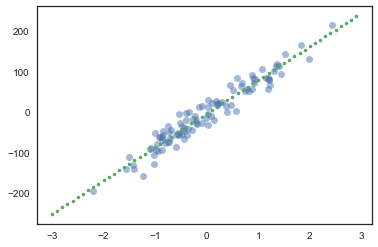

In [41]:
#code adapted from http://tillbergmann.com/blog/python-gradient-descent.html
x, y = make_regression(n_samples = 100, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept, _,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

In [53]:
def gradient_descent(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    m = y.size # number of data points
    theta = theta_init
    history = [] # to store all thetas
    preds = []
    counter = 0
    oldcost = 0
    pred = np.dot(x, theta)
    error = pred - y 
    currentcost = np.sum(error ** 2) / (2 * m)
    preds.append(pred)
    costs.append(currentcost)
    history.append(theta)
    counter+=1
    while abs(currentcost - oldcost) > precision:
        oldcost=currentcost
        gradient = x.T.dot(error)/m 
        theta = theta - step * gradient  # update
        history.append(theta)
        
        pred = np.dot(x, theta)
        error = pred - y 
        currentcost = np.sum(error ** 2) / (2 * m)
        costs.append(currentcost)
        
        if counter % 25 == 0: preds.append(pred)
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
        
    return history, costs, preds, counter

xaug = np.c_[np.ones(x.shape[0]), x]
theta_i = [-1, 1] + np.random.rand(2)
history, cost, preds, iters = gradient_descent(xaug, y, theta_i, step=0.01)
theta = history[-1]
print("Gradient Descent: {:.2f}, {:.2f} {:d}".format(theta[0], theta[1], iters))
print("Least Squares: {:.2f}, {:.2f}".format(intercept, slope))

Gradient Descent: -3.74, 82.51 665
Least Squares: -3.71, 82.90


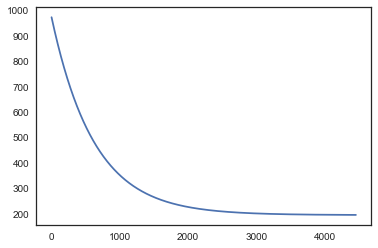

In [49]:
plt.plot(range(len(cost)), cost);


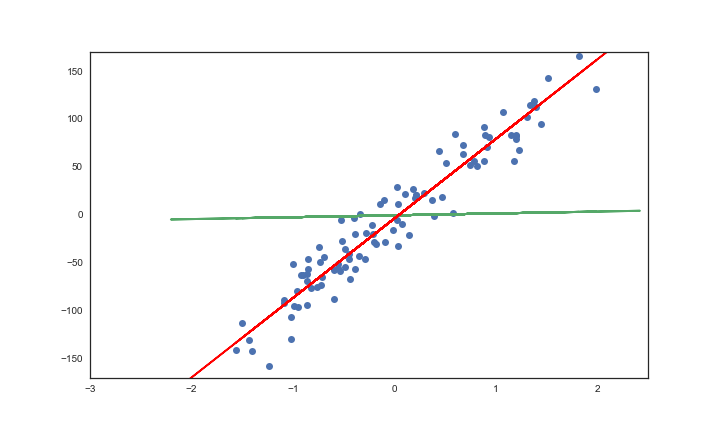
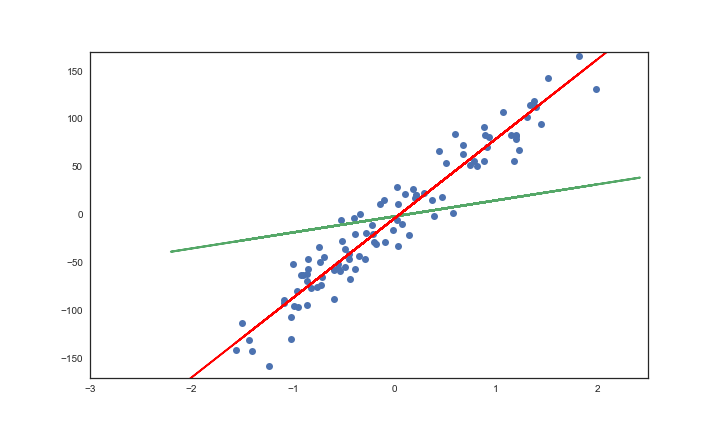
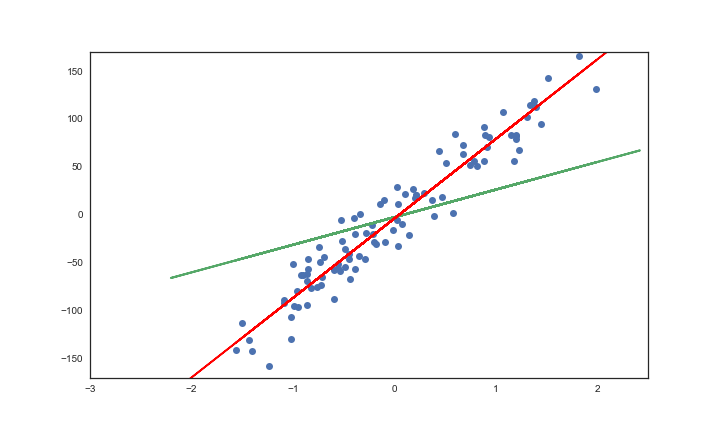
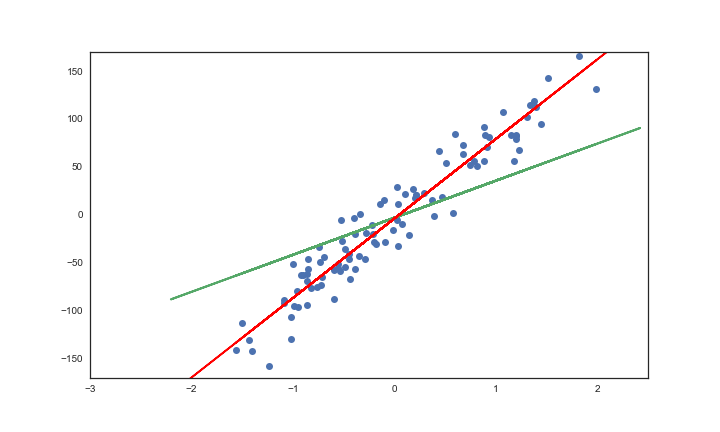
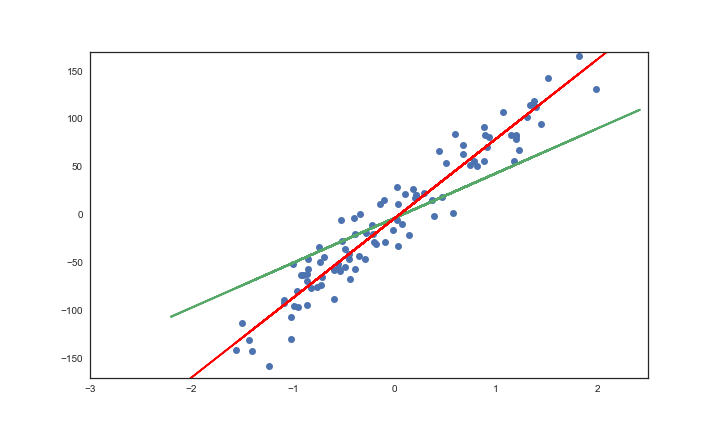
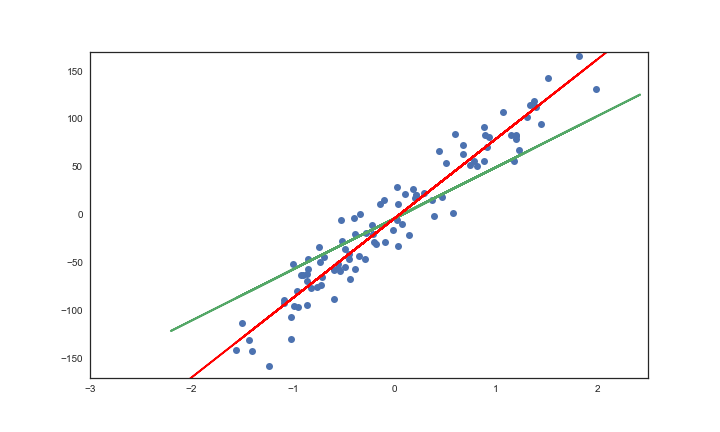
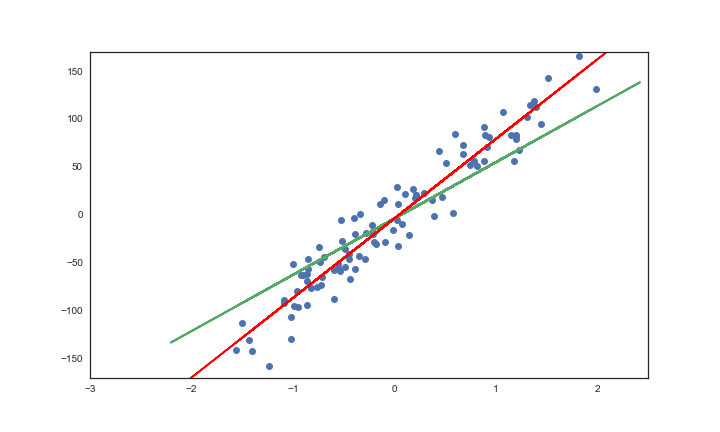
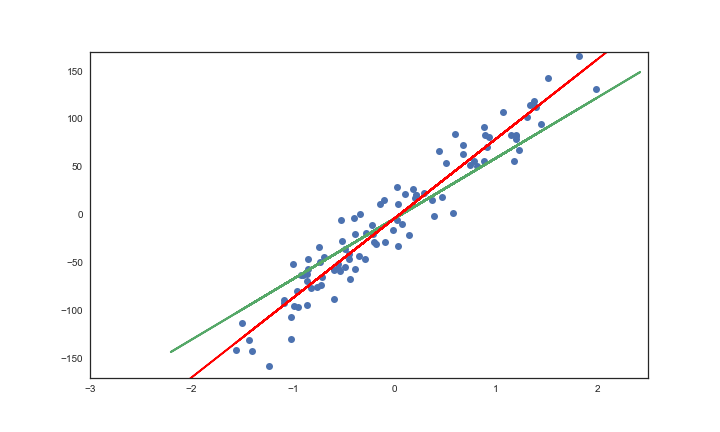
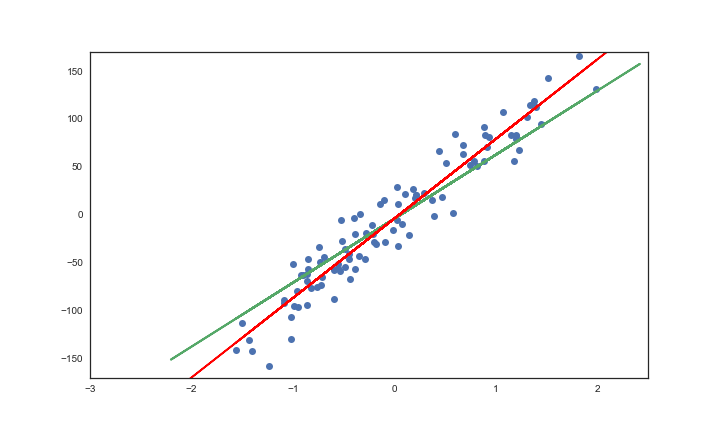
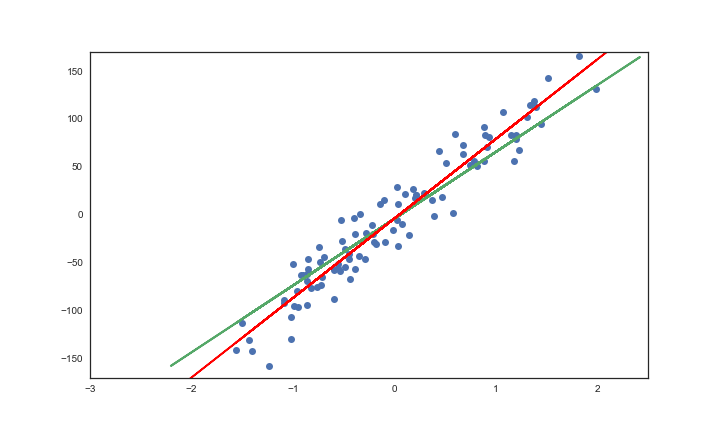
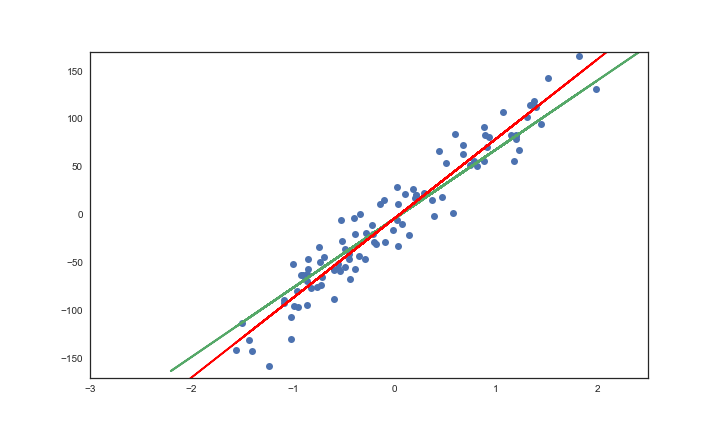
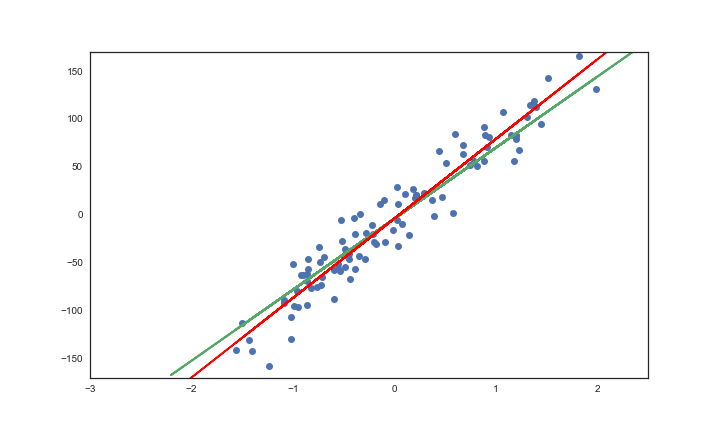
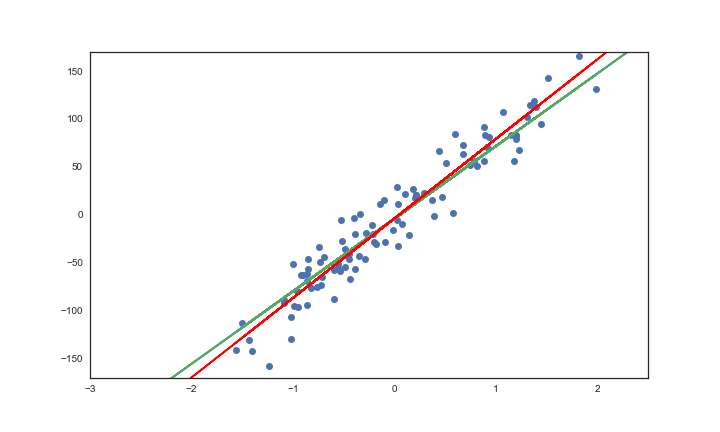
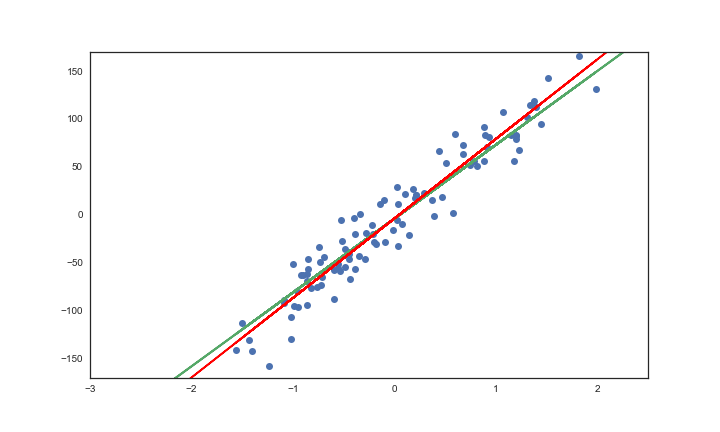
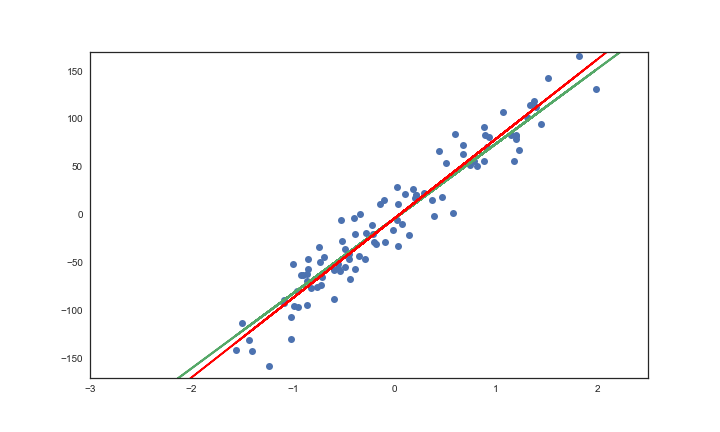
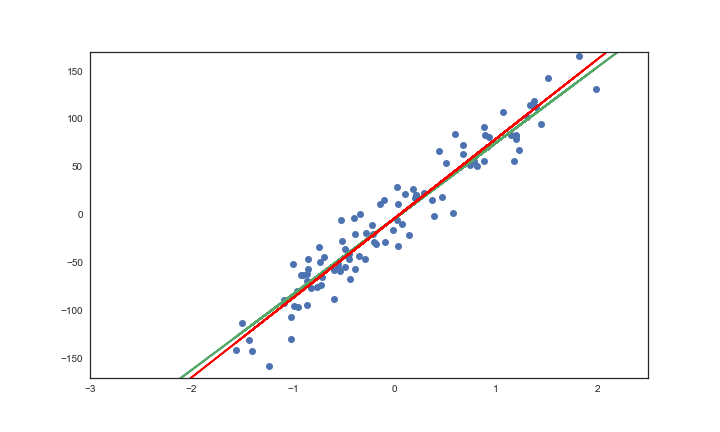
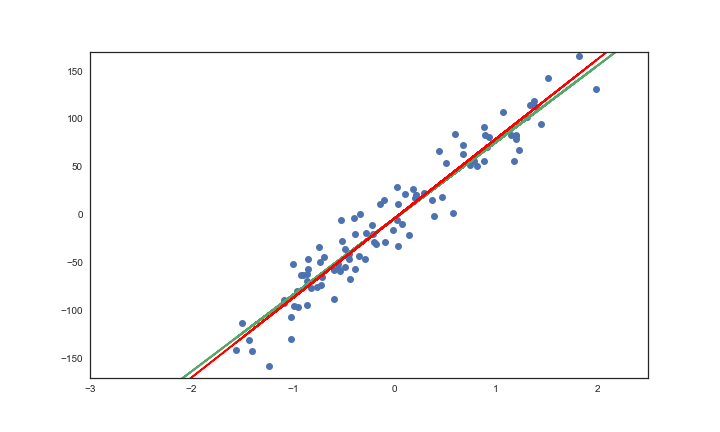
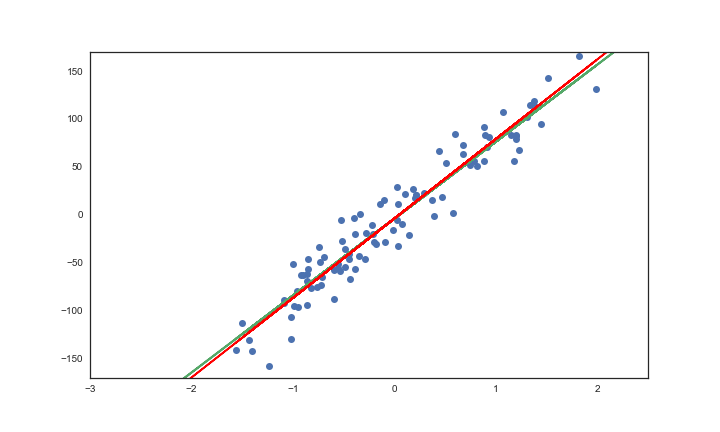
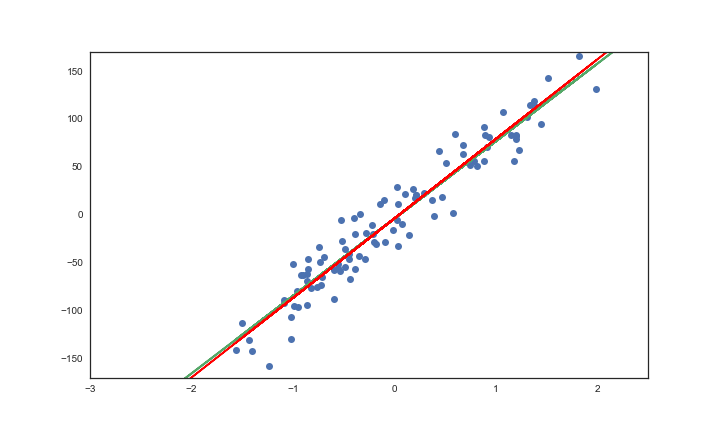
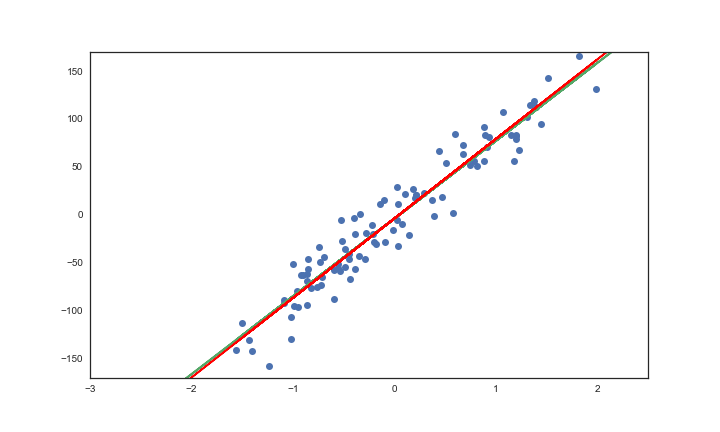
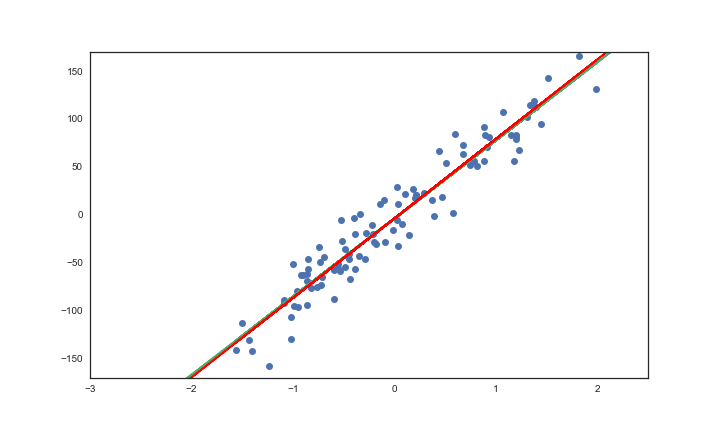
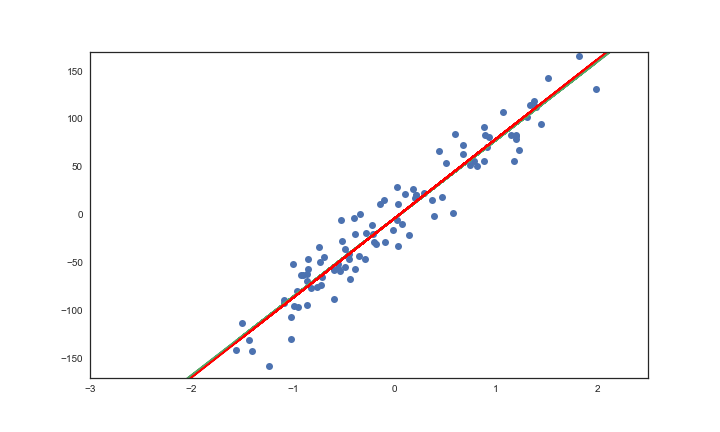
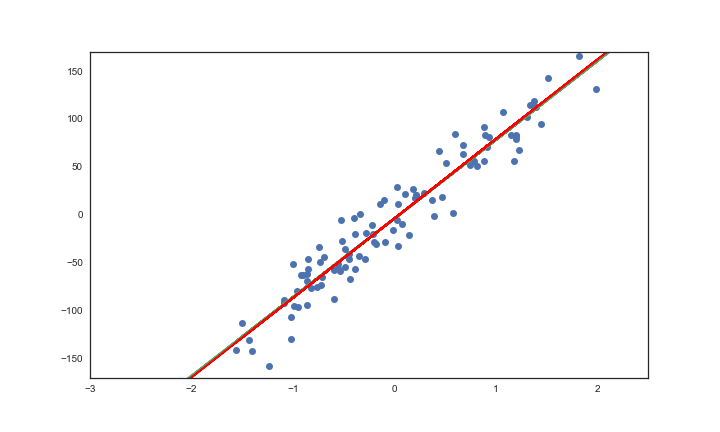
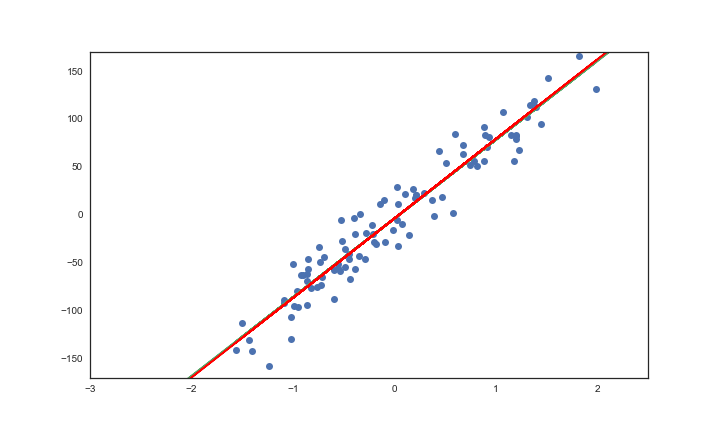
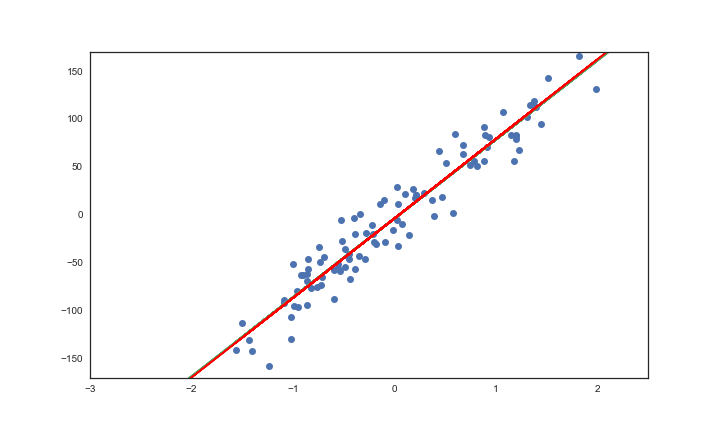
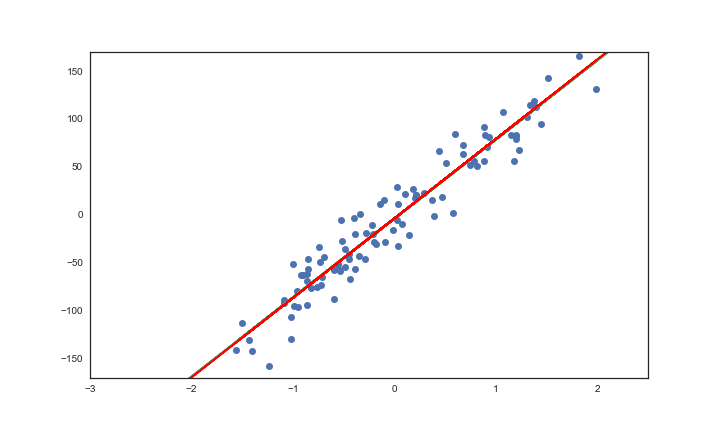
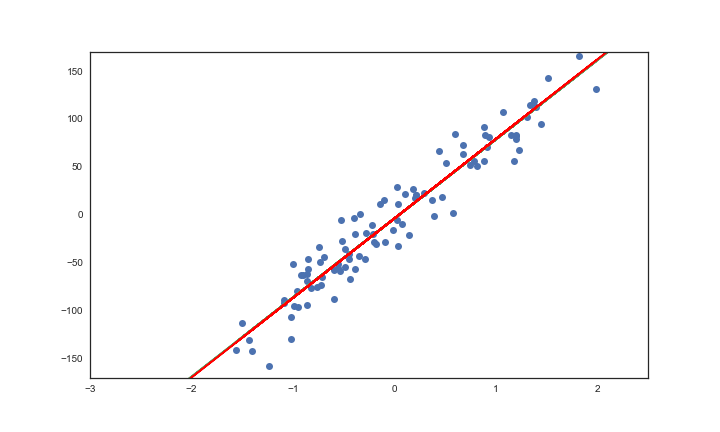

In [54]:
def init():
    line.set_data([], [])
    return line,

def animate(i):
    ys = preds[i]
    line.set_data(xaug[:, 1], ys)
    return line,

fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(-3, 2.5), ylim=(-170, 170))
ax.plot(xaug[:,1],y, 'o')
line, = ax.plot([], [], lw=2)
plt.plot(xaug[:,1], best_fit(xaug[:,1]), 'k-', color = "r")

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(preds), interval=100)
#anim.save('grad_images/gdline.mp4') Errors with html when run in notebook
anim

Converged in 32 steps.



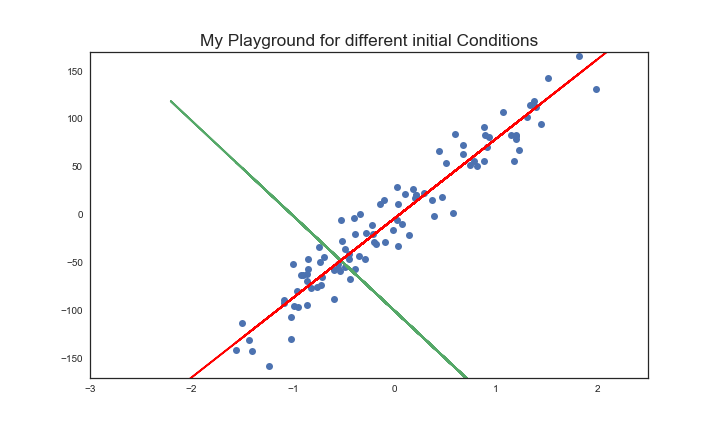
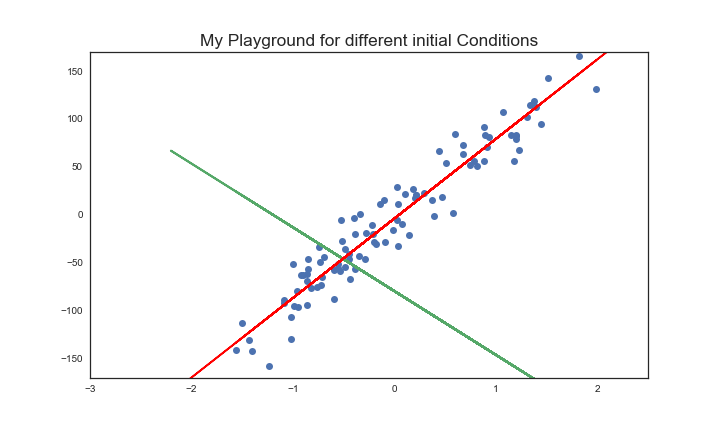
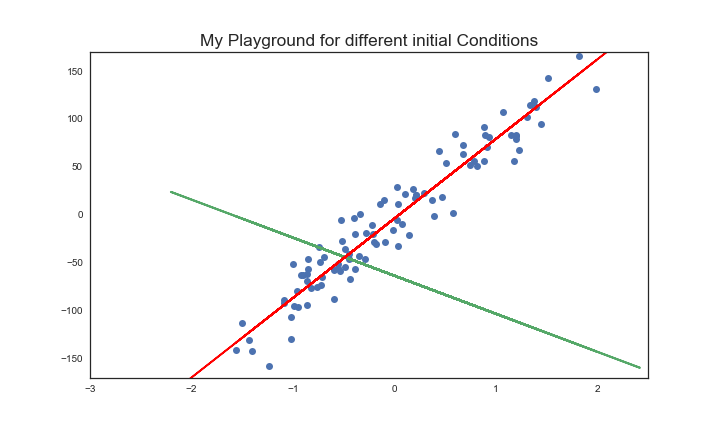
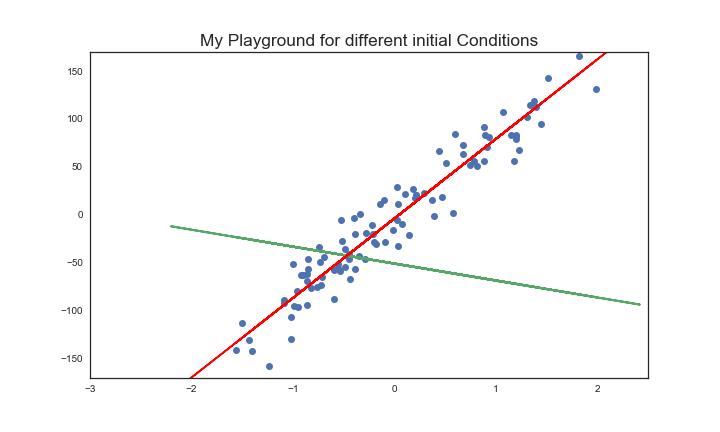
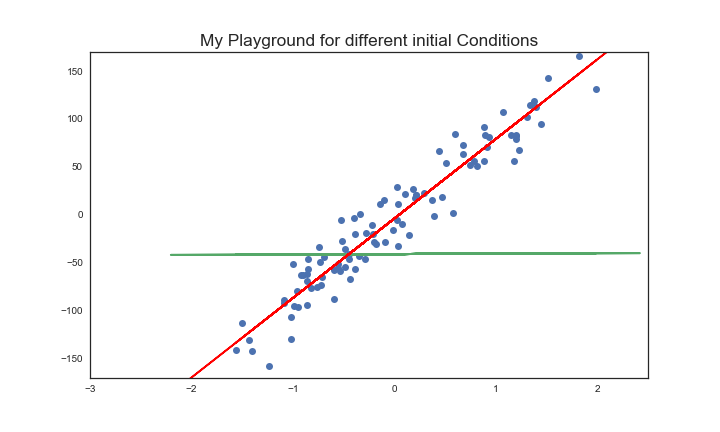
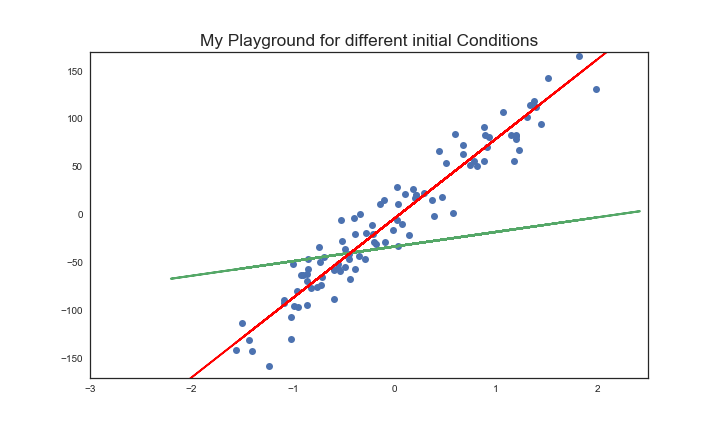
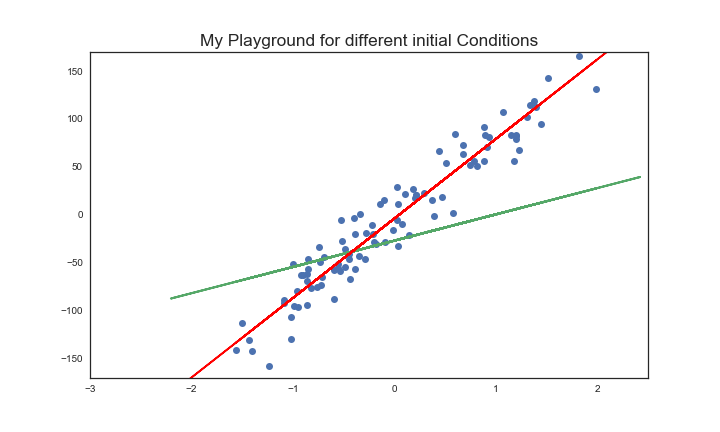
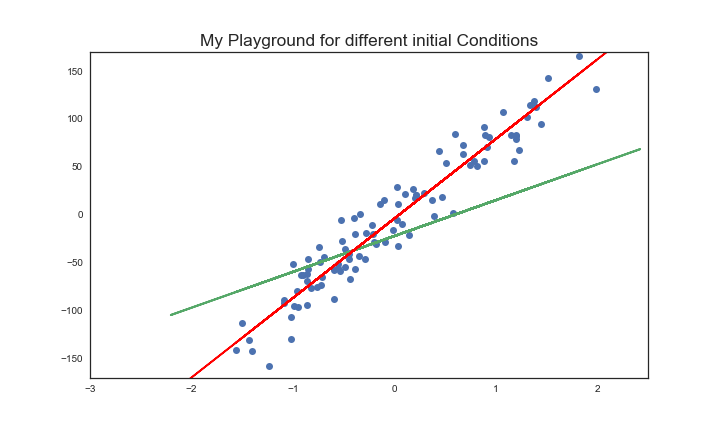
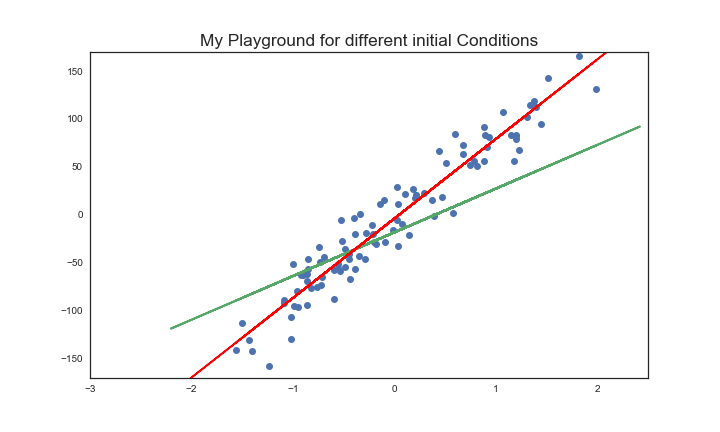
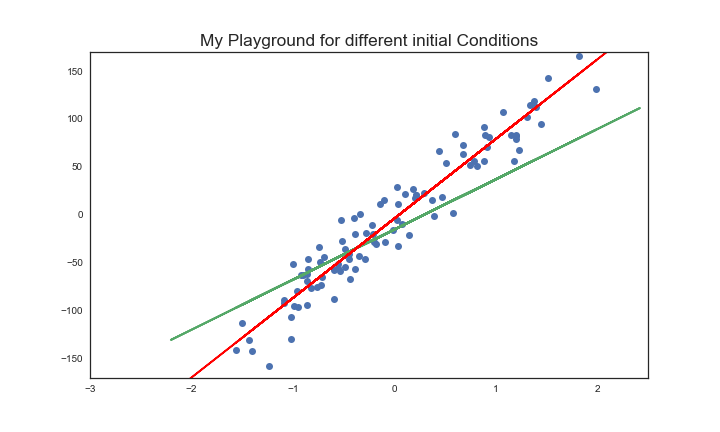
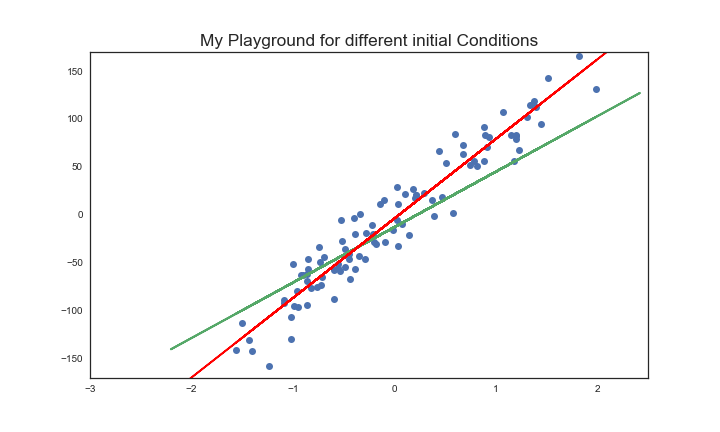
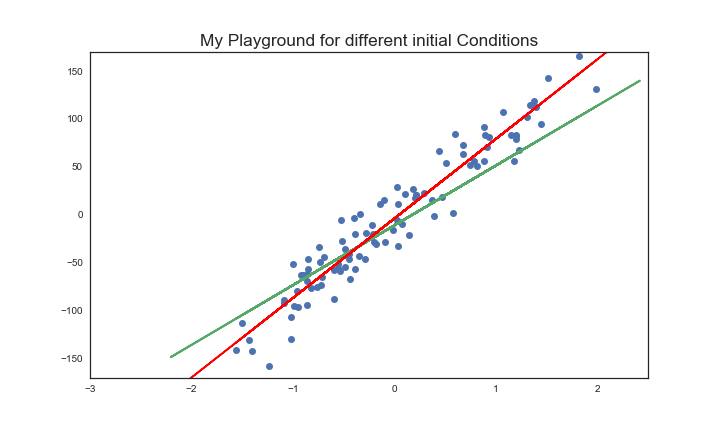
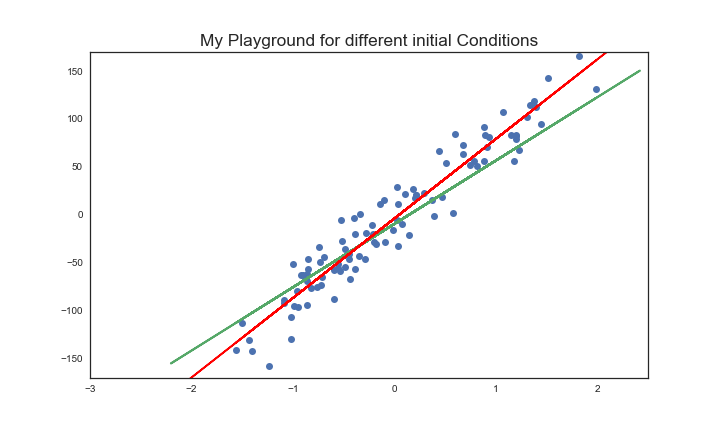
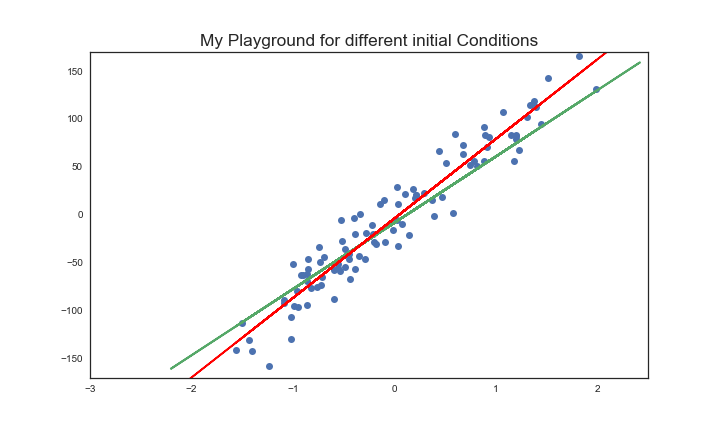
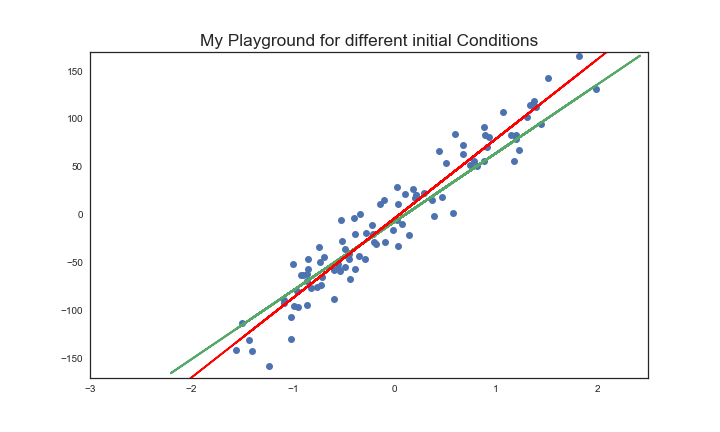
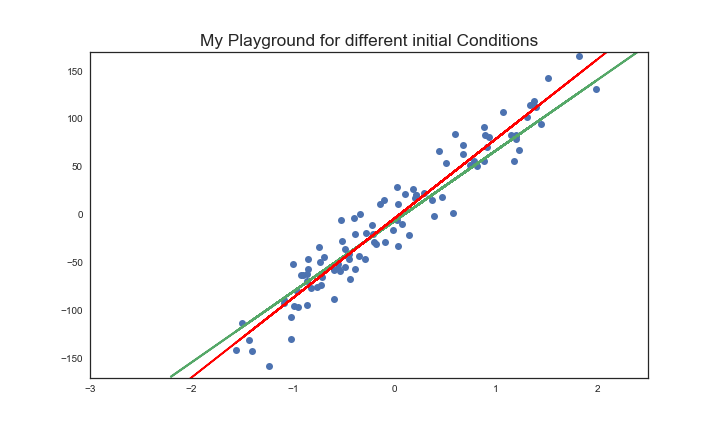
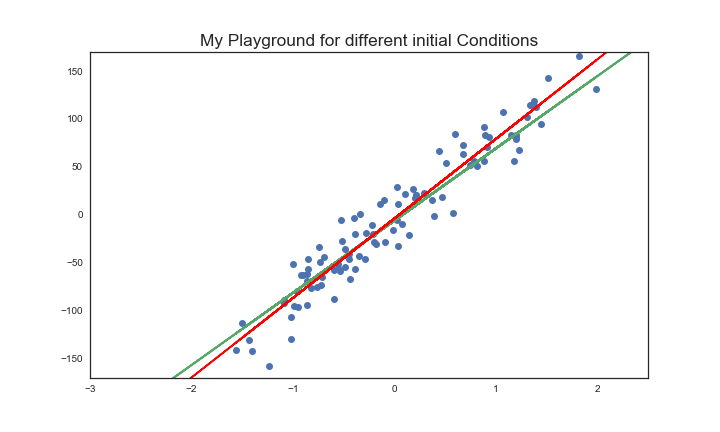
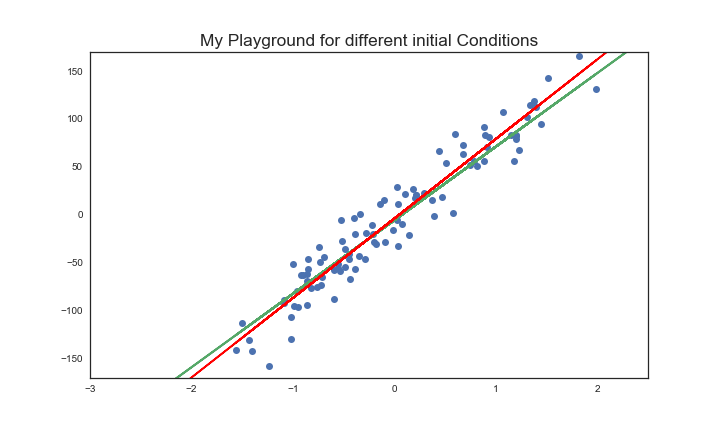
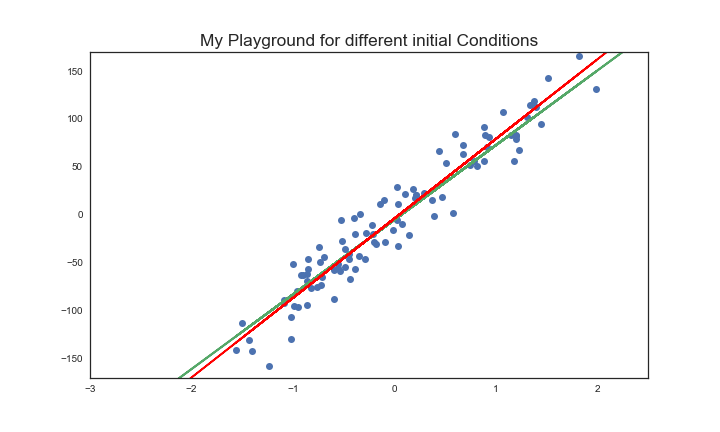
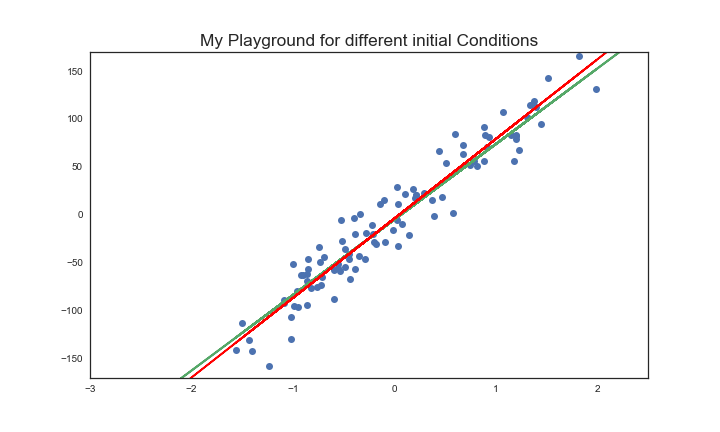
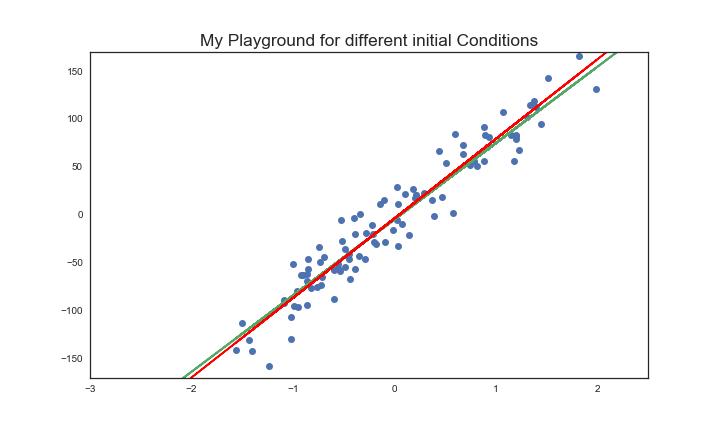
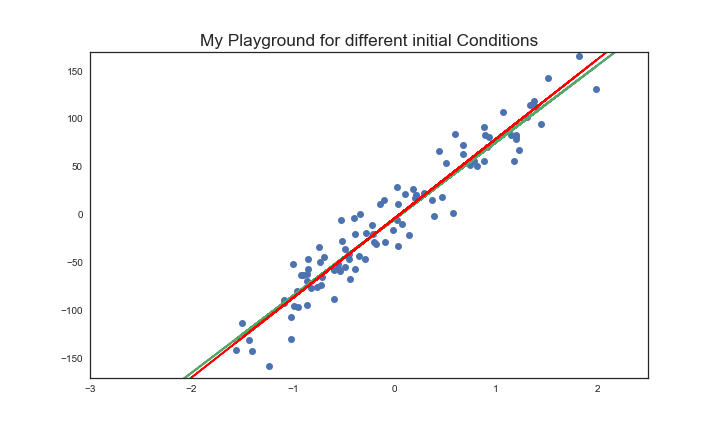
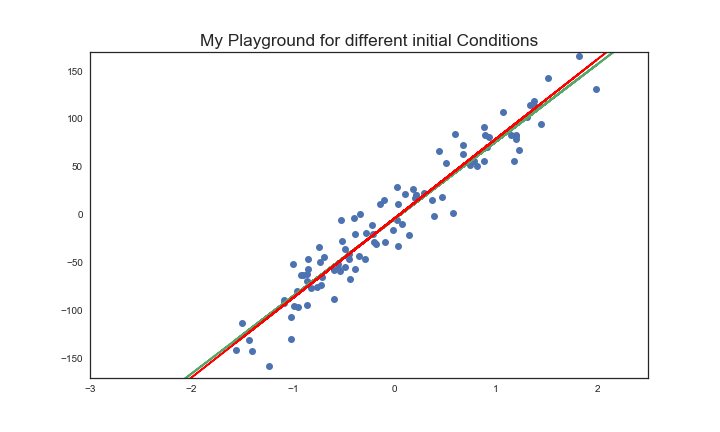
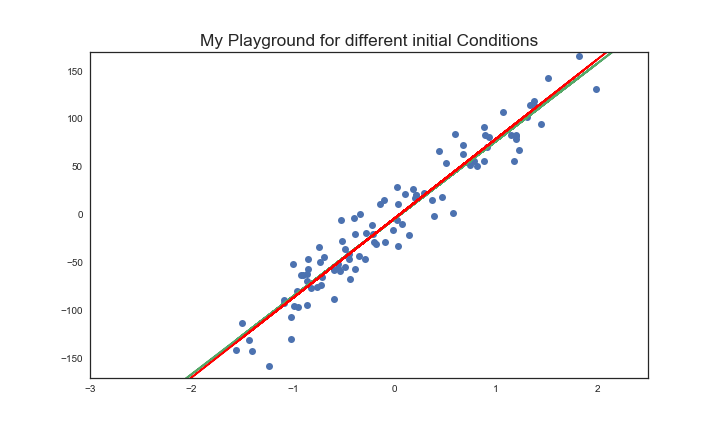
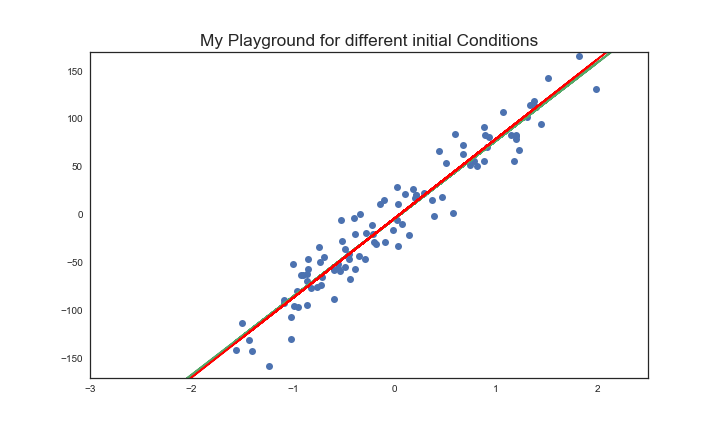
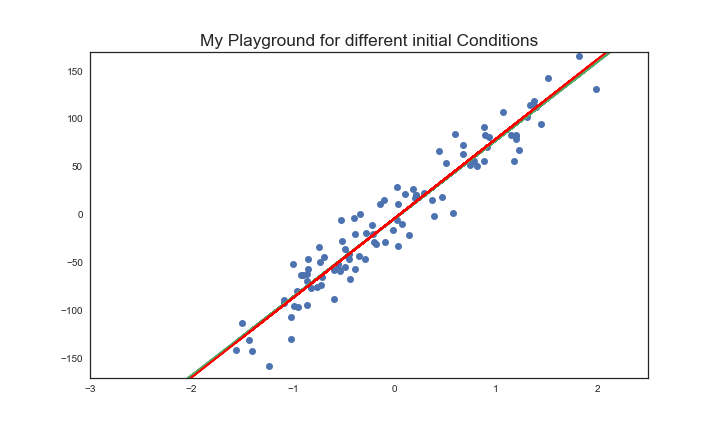
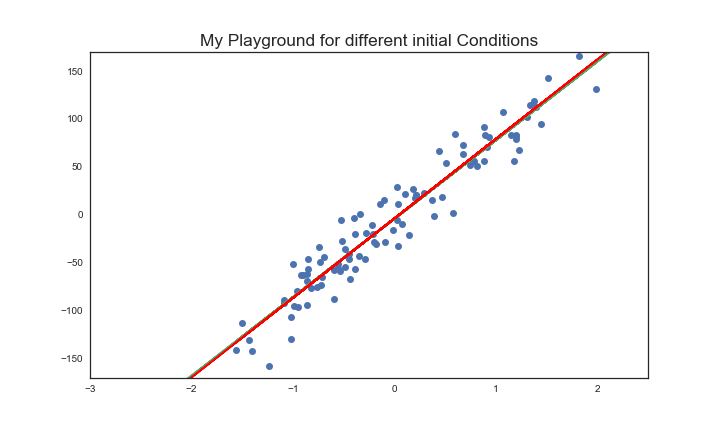
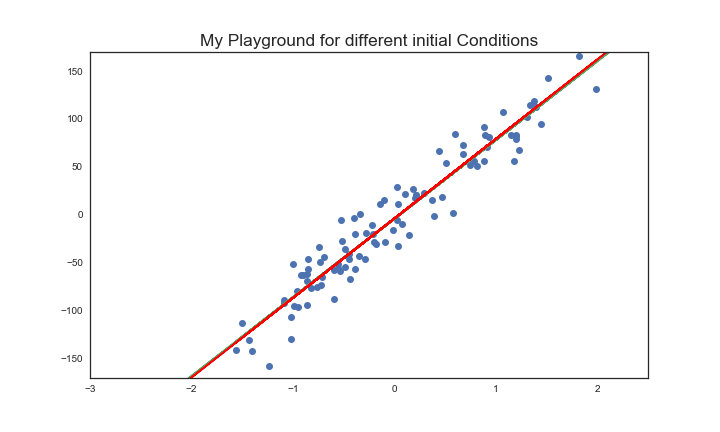
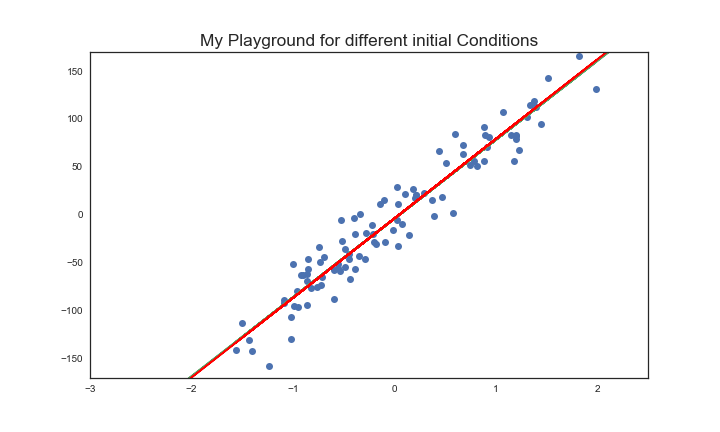
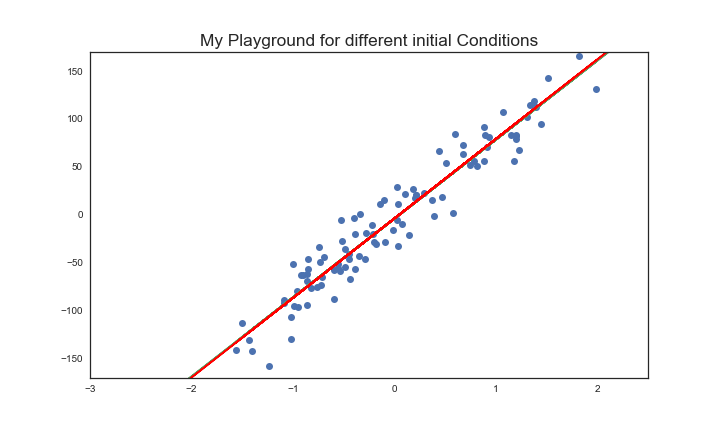
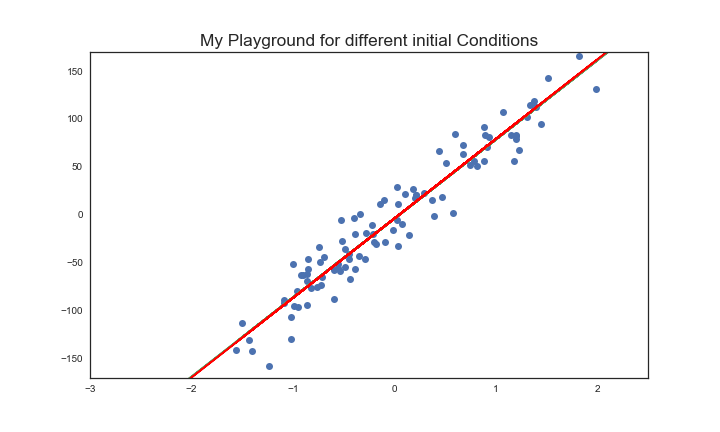
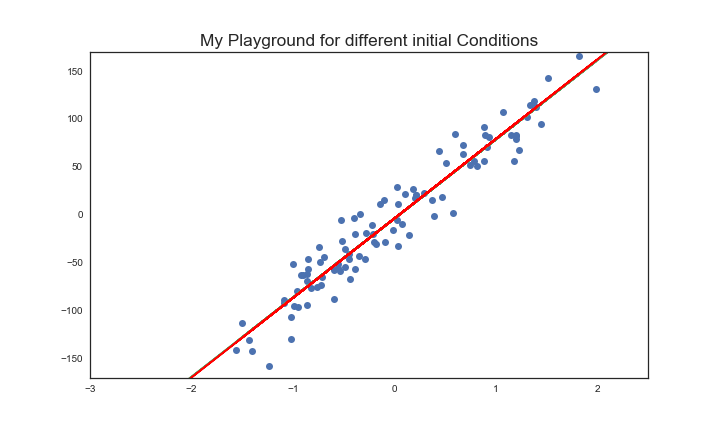

In [60]:
"""
Playground!

Parameters to change:
 * init_theta = [-100, -100] + np.random.rand(2)
 * step=0.01
"""

# TODO change the initial conditions and see how it changes the rate of convergence
init_theta = [-100, -100] + np.random.rand(2)
_, __, preds, ___ = gradient_descent(xaug, y, init_theta, step=0.01)

fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(-3, 2.5), ylim=(-170, 170))
ax.plot(xaug[:,1],y, 'o')
line, = ax.plot([], [], lw=2)

print('Converged in %i steps.' % len(preds))

# Plot the best solution
plt.plot(xaug[:,1], best_fit(xaug[:,1]), 'k-', color = "r")
ax.set_title('My Playground for different initial Conditions', size='xx-large')

# Animate the convergence
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(preds), interval=100)
anim